In [14]:
from KPrincipalGaussiansClassifier import KPrincipalGaussiansClassifier, MetaParams
import pandas as pd

variance_perc_threshold=0.75
model_name = f"../models_storage/mahalanobis_class-specific_{ variance_perc_threshold * 100 }"
print("model name: ", model_name)

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

class_components_weights = [
    1, # 0
    1, # 1
    1, # 2
    1, # 3
    0.7, # 4
    1, # 5
    1, # 6
    0.9, # 7
    1, # 8
    1.4, # 9
]
train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
meta_params = MetaParams(
    num_classes=10,
    class_components_weights=class_components_weights,
    n_init=1,
    tol=1e-2,
    variance_perc_threshold=variance_perc_threshold,
    k_near_centroids=5,
    verbose=0
) 

k_prin_gauss_model = KPrincipalGaussiansClassifier(meta_params=meta_params)
k_prin_gauss_model.fit(train_data=train_data, labels=labels)


model name:  ../models_storage/mahalanobis_class-specific_75.0
loading data
train shape: (42000, 784)
labels shape: (42000,)
PCA k_seg_por_classe: 33
Treinando GaussianMixture para a classe: 0
K componentes ideal para classe 0: 15


c:\src\data_analysis\venv\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Treinando GaussianMixture para a classe: 1
K componentes ideal para classe 1: 7


c:\src\data_analysis\venv\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Treinando GaussianMixture para a classe: 2
K componentes ideal para classe 2: 23
Treinando GaussianMixture para a classe: 3
K componentes ideal para classe 3: 22


c:\src\data_analysis\venv\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Treinando GaussianMixture para a classe: 4
K componentes ideal para classe 4: 14.0


c:\src\data_analysis\venv\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Treinando GaussianMixture para a classe: 5
K componentes ideal para classe 5: 21
Treinando GaussianMixture para a classe: 6
K componentes ideal para classe 6: 17
Treinando GaussianMixture para a classe: 7
K componentes ideal para classe 7: 14.4
Treinando GaussianMixture para a classe: 8
K componentes ideal para classe 8: 25
Treinando GaussianMixture para a classe: 9
K componentes ideal para classe 9: 23.799999999999997


[1, 1, 1, 1, 0.7, 1, 1, 0.9, 1, 1.4]
loading data
train shape: (42000, 784)
labels shape: (42000,)


100%|██████████████████████████████████| 42000/42000 [00:03<00:00, 12171.77it/s]

Precisão: 0.9659285714285715


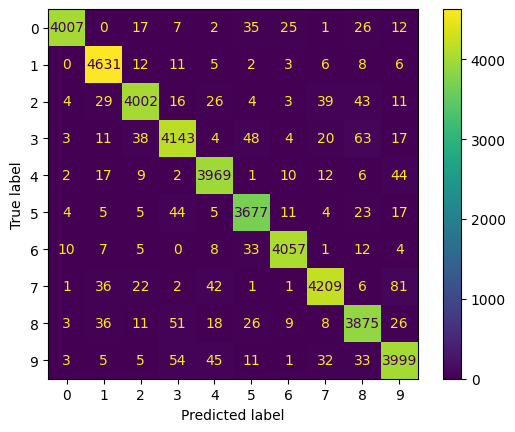

In [15]:
# validar localmente
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Salvar modelo
'''
    Aqui salvamos o modelo para economizar tempo nas próximas execuções e armazenar os resultados.
'''
import numpy as np
np.save(model_name, [k_prin_gauss_model], allow_pickle=True)

print(k_prin_gauss_model.class_components_weights)

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)

loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = loaded_arr[0]
num_samples = 42000
validation_data = train_data[:num_samples,:]
labels_v = labels[:num_samples]
predictions = kgmm.predict(validation_data)
    
print("Precisão:", len(predictions[labels_v == predictions]) / num_samples)

# Compute confusion matrix
cm = confusion_matrix(labels_v, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

loading data
train shape: (42000, 784)
labels shape: (42000,)


k=1: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15688.91it/s]


k=1 => pontos 90.73571428571428% representados


k=2: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15601.78it/s]


k=2 => pontos 95.03809523809524% representados


k=3: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15567.09it/s]


k=3 => pontos 96.69761904761904% representados


k=4: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15435.50it/s]


k=4 => pontos 97.51904761904761% representados


k=5: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15535.21it/s]


k=5 => pontos 98.04047619047618% representados


k=6: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15494.31it/s]


k=6 => pontos 98.46428571428572% representados


k=7: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15463.33it/s]


k=7 => pontos 98.72142857142858% representados


k=8: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 15202.99it/s]


k=8 => pontos 98.92619047619048% representados


k=9: 100%|█████████████████████████████| 42000/42000 [00:02<00:00, 14714.05it/s]


k=9 => pontos 99.08333333333333% representados


k=10: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 14940.93it/s]


k=10 => pontos 99.24047619047619% representados


k=11: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 15129.47it/s]


k=11 => pontos 99.34285714285714% representados


k=12: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 15092.55it/s]


k=12 => pontos 99.43809523809523% representados


k=13: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 14878.21it/s]


k=13 => pontos 99.52142857142857% representados


k=14: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 15043.00it/s]


k=14 => pontos 99.57619047619048% representados


k=15: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 14957.06it/s]


k=15 => pontos 99.63333333333333% representados


k=16: 100%|████████████████████████████| 42000/42000 [00:02<00:00, 14935.74it/s]

k=16 => pontos 99.69285714285714% representados


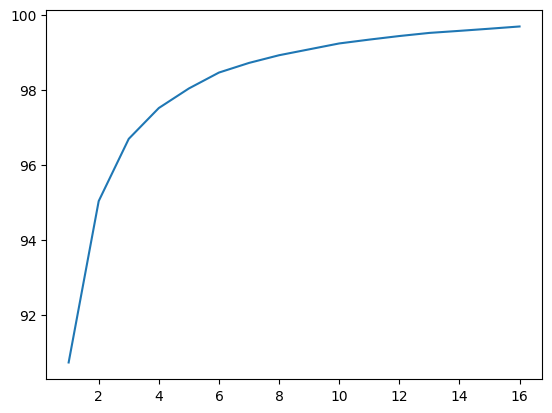

In [29]:
''' 
  98.1 % de acerto nos dados de treino já é uma boa marca, mas esse valor pode melhorar.
  O grande problema é que as porcentagens de erro ocorrem quando há uma relação discreta e não linear que o nosso modelo não coneseguiu aprender.
  Aumentar o número de segmentos irá aumentar o tempo de treinamento e gerar overfitting.
  Para representar adequadamente essas relações não lineares entre as classes e permitir que nosso modelo tenha uma taxa maior de acerto, 
  ao invés de usarmos a menor distância de mahalanobis para determinar a resposta da classificação, iremos criar uma rede neural para 
  apreender estes relacionamentos. 
  
  Para conseguirmos fazer isso de forma eficiente no nosso contexto, buscaremos passar o mínimo de informações possíveis para a rede neural.
  Desta forma, o metaparâmetro mais relevante é o número de segmentos próximos retornados pela busca usando a distância euclidiana como método.
  precisamos saber qual é o k mínimo que encontra em todos os casos a gaussiana da classe correta, 
  ainda que ela possua uma distância de mahalanobis maior do que a classe que o modelo respondeu.
  
  Nesta célula encontraremos o número de k_segmentos_proximos a partir de um modelo de gaussianas pré treinado.
'''

# validar localmente
import numpy as np
import pandas as pd
from tqdm import tqdm
from search_optimization import find_closest_segments
import matplotlib.pyplot as plt
 
def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = loaded_arr[0]
num_samples = 42000
labels_v = labels[:num_samples]
validation_data = train_data[:num_samples,:]

meta_params = kgmm.meta_params
search_index = kgmm.hnsw
porcentagens_representacao = []
transformed_points = kgmm.pca.transform(validation_data)

'''
  Aqui usamos 16 como máximo do k por conta do máximo que colocamos na nossa otimização  
'''
for k in range(1, 17):
  meta_params.k_near_centroids = k
  pontos_representados = 0
  for idx in tqdm(range(len(train_data)), desc=f"k={k}",ncols=80, colour="blue"): 
    p = transformed_points[idx]
    label = labels_v[idx]
    indices = find_closest_segments(hnsw=search_index, point=p, metaparams=meta_params)
    classes = (indices // (kgmm.k_segments_per_class)).astype(int) 
    if (np.isin(label, classes)):
      pontos_representados += 1
  porcentagem = pontos_representados/num_samples * 100
  porcentagens_representacao.append(porcentagem)
  print(f"k={k} => pontos {porcentagem}% representados")
  if (porcentagem == 100):
    break;

plt.plot(np.arange(1,17,1), porcentagens_representacao)

In [8]:
'''Como foi possível notar pela execução anterior, o maior valor que conseguimos representar,
colocando uma restrição de 16 gaussianas para a busca euclidiana foi de 99.44%.
Por enquanto, iremos assumir que esses 0.66% são outliers, mas já conseguimos perceber uma limitação no
modelo. Mesmo se conseguirmos 100% de acerto na rede neural, usando os dados de treino teríamos no máximo 99.44% de acerto.
Para melhorar este número, o correto seria mudarmos a métrica da distância, e, ao invés de usar a distância euclidiana na busca
usar a distância de mahalanobis, tanto na criação da representação, quando no momento da busca.
Por enquanto iremos deixar como está e iremos focar em melhorar a performance geral usando uma rede neural.
'''

'Como foi possível notar pela execução anterior, o maior valor que conseguimos representar,\ncolocando uma restrição de 16 gaussianas para a busca euclidiana foi de 99.44%.\nPor enquanto, iremos assumir que esses 0.66% são outliers, mas já conseguimos perceber uma limitação no '

In [16]:
''' Gerar submissão '''
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgm = loaded_arr[0]  
file_path = '../data/digit-recognizer/test.csv' 
test_data = pd.read_csv(file_path)
data_points = test_data.to_numpy()
 
test_data.loc[:, "Label"] = kgm.predict(data_points).astype(int)
answer = test_data[["Label"]].copy() 
answer["ImageId"] = range(1, len(answer) + 1)  
answer = answer[["ImageId", "Label"]]

# Save to CSV
output_file = f"{model_name}.csv"
answer.to_csv(output_file, index=False)

100%|██████████████████████████████████| 28000/28000 [00:02<00:00, 12163.13it/s]
